In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from packages.DataAugmentation import dataAugmentation
from packages.DataProcessing import tfrecords
from packages.Model_EfficientNet import get_model

plt.style.use('_mpl-gallery')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [2]:
N_SPLITS = 4
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 100
PATIENCE = 10
MAX_LR = 1e-4
MIN_LR = 1e-5

In [3]:
class_names = np.load("./output/class_names.npy", allow_pickle=True)
num_classes = len(class_names)

In [4]:
train_target = np.load("./output/train_target.npy", allow_pickle=True)
valid_target = np.load("./output/valid_target.npy", allow_pickle=True)

In [5]:
# Reading TFRecords
records = tfrecords(IMG_HEIGHT, IMG_WIDTH)
train_ds = records.get_dataset('./output/tfrecords/train.tfrecords')
valid_ds = records.get_dataset('./output/tfrecords/valid.tfrecords')

In [6]:
# Data augmentation
aug_train = dataAugmentation()
train_ds = train_ds.map(aug_train.augment_iamge, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()

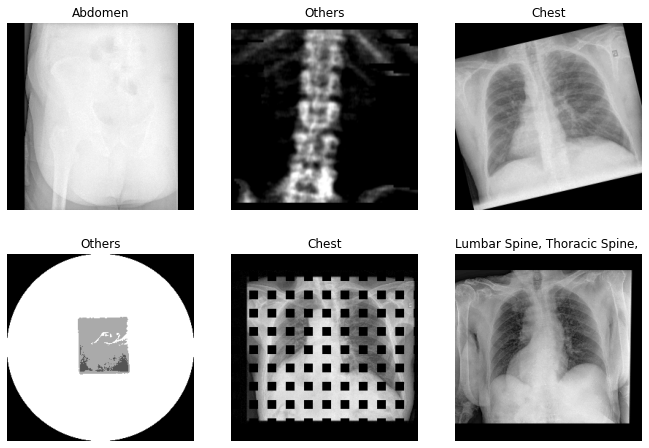

In [8]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(9, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    label = label_batch[i].numpy()
    if label.sum() == 1:
        plt.title(class_names[np.argmax(label)])
    else:
        titles = ""
        for j in np.where(label == 1)[0]:
            titles = titles + class_names[j] + ", "
        plt.title(titles)
    plt.axis("off")
plt.show()

In [9]:
# Build Model

model = get_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), output_shape=num_classes)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 tf.tile (TFOpLambda)        (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 22)                28182 

In [11]:
# train_classes, train_counts = np.unique(train_target, return_counts=True)
train_counts = train_target.sum(axis=0)

weight = (1/train_counts) * (len(train_target)/num_classes)
class_weight = {i:weight[i] for i in range(len(weight))}

In [12]:
steps_per_epoch = len(train_target)//BATCH_SIZE
validation_steps = len(valid_target)//BATCH_SIZE

In [13]:
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=MAX_LR,
                                                     total_steps=EPOCHS*steps_per_epoch,
                                                     warmup_proportion=0.2,
                                                     min_lr=MIN_LR), 
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=PATIENCE, 
                                                monitor='val_loss', 
                                                restore_best_weights=True)

In [15]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs=EPOCHS,
                    callbacks=[my_callbacks],
                    class_weight=class_weight,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/100
81/81 [==============================] - 81s 544ms/step - loss: 3.1531 - accuracy: 0.0448 - val_loss: 3.3218 - val_accuracy: 0.0394
Epoch 2/100
81/81 [==============================] - 49s 536ms/step - loss: 3.1369 - accuracy: 0.0388 - val_loss: 3.2928 - val_accuracy: 0.0370
Epoch 3/100
81/81 [==============================] - 43s 529ms/step - loss: 3.0901 - accuracy: 0.0435 - val_loss: 3.2695 - val_accuracy: 0.0417
Epoch 4/100
81/81 [==============================] - 44s 548ms/step - loss: 3.0500 - accuracy: 0.0528 - val_loss: 3.2188 - val_accuracy: 0.0741
Epoch 5/100
81/81 [==============================] - 44s 548ms/step - loss: 3.0502 - accuracy: 0.0675 - val_loss: 3.1617 - val_accuracy: 0.1227
Epoch 6/100
81/81 [==============================] - 45s 556ms/step - loss: 2.9406 - accuracy: 0.0792 - val_loss: 3.0752 - val_accuracy: 0.1713
Epoch 7/100
81/81 [==============================] - 47s 575ms/step - loss: 2.8822 - accuracy: 0.1134 - val_loss: 2.9692 - val_accuracy:

In [16]:
model.save(f'./output/model_E.h5')

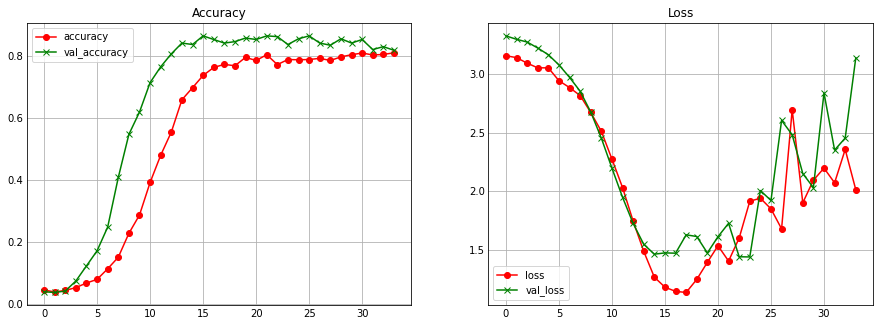

In [17]:
# Validate the Model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.plot(history.history['accuracy'], 'r', marker="o", label='accuracy')
ax1.plot(history.history['val_accuracy'], 'g', marker="x", label='val_accuracy')
ax1.legend()

ax2.set_title('Loss')
ax2.plot(history.history['loss'], 'r', marker="o", label='loss')
ax2.plot(history.history['val_loss'], 'g', marker="x", label='val_loss')
ax2.legend()

plt.show()

In [18]:
import os
import pydicom 
import warnings

warnings.filterwarnings("ignore")

In [ ]:
def process_data_test(path):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array
    if ds.PhotometricInterpretation == 'MONOCHROME1':
        img = np.invert(img)
    img = (img/(2**ds.BitsAllocated - 1)*255).astype('uint8')
    img = img - img.min()
    img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    img = tf.cast(img, 'uint8')
    return img

In [24]:
path_images = []
folder = ".\\input\\test\\test\\"
for root, dirs, files in os.walk(folder, topdown=False):
    if files:
        if files[0][-3:] == 'dcm':
            path_images.append(root + "\\" + files[0])

In [21]:
df = pd.read_csv('./input/sample_submission.csv')

In [22]:
df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
...,...,...
738,1.2.826.0.1.3680043.8.498.98950979295424909746...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
739,1.2.826.0.1.3680043.8.498.99120415799121180043...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
740,1.2.826.0.1.3680043.8.498.99132008951330408682...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
741,1.2.826.0.1.3680043.8.498.99611256581875030709...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
